# Controlling Plotting Functions

> **Note**
>
> Download the example file here: [HP3_TE300_SPC630.hdf5](https://zenodo.org/record/5902313/files/HP3_TE300_SPC630.hdf5)

First, let's run the following code to generate a basic analysis for us to begin working with.
This code is essential the same as that found in the [tutorial](#Tutorial).

In [1]:
import numpy as np
from matplotlib import pyplot as plt

import fretbursts as frb
import burstH2MM as bhm

filename = 'HP3_TE300_SPC630.hdf5'
# load the data into the data object frbdata
frbdata = frb.loader.photon_hdf5(filename)
# if the alternation period is correct, apply data
# plot the alternation histogram
# frb.bpl.plot_alternation_hist(frbdata) # commented so not displayed in notebook
frb.loader.alex_apply_period(frbdata)
# calcualte the background rate
frbdata.calc_bg(frb.bg.exp_fit, F_bg=1.7)
# plot bg parameters, to verify quality
# frb.dplot(frbdata, frb.hist_bg) # commented so not displayed in notebook
# now perform burst search
frbdata.burst_search(m=10, F=6)
# make sure to set the appropriate thresholds of ALL size
# parameters to the particulars of your experiment
frbdata_sel = frbdata.select_bursts(frb.select_bursts.size, th1=50)
# make BurstData object to get data into bursth2MM
bdata = bhm.BurstData(frbdata_sel)
# calculate models
bdata.models.calc_models()

 - Optimized (cython) burst search loaded.
 - Optimized (cython) photon counting loaded.
--------------------------------------------------------------
 You are running FRETBursts (version 0.7.1).

 If you use this software please cite the following paper:

   FRETBursts: An Open Source Toolkit for Analysis of Freely-Diffusing Single-Molecule FRET
   Ingargiola et al. (2016). http://dx.doi.org/10.1371/journal.pone.0160716 

--------------------------------------------------------------
# Total photons (after ALEX selection):    11,414,157
#  D  photons in D+A excitation periods:    5,208,392
#  A  photons in D+A excitation periods:    6,205,765
# D+A photons in  D  excitation period:     6,611,308
# D+A photons in  A  excitation period:     4,802,849

 - Calculating BG rates ... get bg th arrays
Channel 0
[DONE]
 - Performing burst search (verbose=False) ...[DONE]
 - Calculating burst periods ...[DONE]
 - Counting D and A ph and calculating FRET ... 
   - Applying background correction

The model converged after 5 iterations

The model converged after 36 iterations

The model converged after 124 iterations

The model converged after 408 iterations

2

<a id='custstateplot'></a>
## Global Plot Customizations

The central plotting functions of burstH2MM are all highly customizable.

The first and simplest form of customization is using the `ax` keyword argument, which is universal to all plotting functions. 
This lets you make a [matplotlib.axes](https://matplotlib.org/stable/api/axes_api.html) (usually made with [plt.subplots()](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html#matplotlib.pyplot.subplots) or related functions), and then plot all elements within that axes. 
This also lets overlapping different plots into one axes.

So here’s an example, and we’ll set the title of the axes afterward:

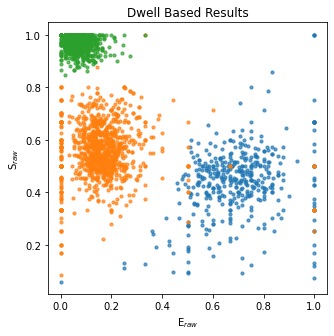

In [2]:
# make the axes
fig, ax = plt.subplots(figsize=(5,5))
bhm.dwell_ES_scatter(bdata.models[2], ax=ax)
ax.set_title("Dwell Based Results");

For E and S based parameters, there is the option to use the raw values (calculated from the photons alone), or the values corrected for the values set for leakage, direct excitation, *gamma* and *beta* that have been set in the `fretbursts.Data` object used to create the BurstData object that you are working on. 
For dwell based parameters, corrections for background are also applied.

> **Note**
>
> See the [On demand data creation section](#datacreation) to understand how, and most importantly when parameters are calculated. 
> Make sure that your `leakage`, `dir_ex`, `gamma` and `beta` values are set before you try to plot or otherwise access any dwell value that involves correcting for these factors. 
> If you want to recalculate, use the `H2MM_result.trim_data()` method on your `H2MM_result` object to clear the value:

This is done quite simply using the `add_corrections` keyword argument:

   - Applying background correction.
   - Applying leakage correction.
   - Applying background correction.
   - Applying leakage correction.
   - Applying direct excitation correction.


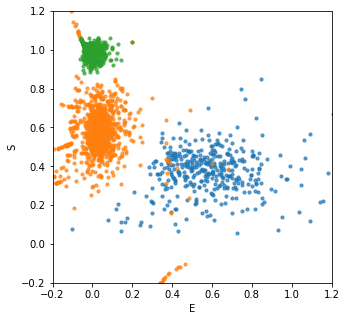

In [3]:
# trim data, NOT necessary if corrected values have not been accessed yet
bdata.models[2].trim_data()

fig, ax = plt.subplots(figsize=(5,5))
# add correction factors (determine for your own setup)

bdata.data.leakage = 0.0603
bdata.data.dir_ex = 0.0471
bdata.data.gamma = 1.8
bdata.data.beta = 0.69
# note the addition of add_corrections=True
bhm.dwell_ES_scatter(bdata.models[2], add_corrections=True, ax=ax)
# set limits on the values, since with corrections, some dwells with
# few photons in a stream will have extreme values
ax.set_xlim([-0.2, 1.2])
ax.set_ylim([-0.2, 1.2]);

<a id='by_state'></a>
## Customizing plots by state

Additional customizations focus on how states are individually plotted. 
This is done by passing lists of keyword argument dictionaries to specific keyword arguments.

The first of these keyword arguments we will explore is `state_kwargs`. 
This is universal to all plotting functions beginning with `dwell_`. 
For it you pass a list of dictionaries of keyword arguments for the underlying matploplib function, one dictionary for each state.

Here’s a simple example, where we assign a color to each state in the `dwell_ES_scatter()` plot:

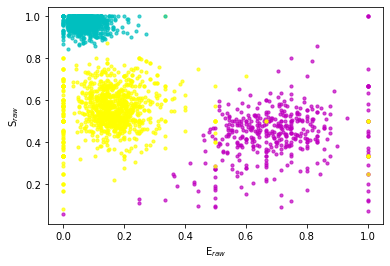

In [4]:
# set up list, same length as number of states in the model
state_color = [{'color':'m'}, {'color':'yellow'}, {'color':'c'}]
bhm.dwell_ES_scatter(bdata.models[2], state_kwargs=state_color);

So what happened here? Since `models[2]` has 3 states, the input state_kwargs keyword argument needs to be a list or tuple of length 3. 
The model stores states in arrays, which gives the states an arbitrary order. 
Each element of the list is passed per state to the [ax.scatter()](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.scatter.html#matplotlib.axes.Axes.scatter) function as keyword arguments, according to the order established in the model. 
So the first state gets the keyword argument `color='m'`, the second state `color='yellow'` and the third `color='m'`.

> **Note**
> 
> The different plotting functions use different matplotlib and seaborn functions. 
> So plotting functions that create histograms use [ax.hist()](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.hist.html#matplotlib.axes.Axes.hist), while scatter functions use [ax.scatter()](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.scatter.html#matplotlib.axes.Axes.scatter), and kde plot functions use [sns.kdeplot()](https://seaborn.pydata.org/generated/seaborn.kdeplot.html)


<a id='statedisp'></a>
### Displaying subsets of states

What if you want to only look at a few states? 
You can select, and control the order of the plotting of different states with the `states` keyword argument.

Let’s say we want to only look at the FRET states (which are the 0th and 1st states in sample data set, but might be different when you are using other datasets). 
To do this, we make an array of just the indices of those states, and then pass that array to the states keyword argument:

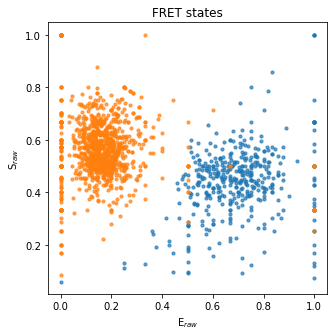

In [5]:
# make the axes
fig, ax = plt.subplots(figsize=(5,5))

# specify the states we want
states = np.array([0, 1])

# now we plot
bhm.dwell_ES_scatter(bdata.models[2], ax=ax, states=states)
ax.set_title("FRET states");

### Selecting states and controlling their plotting

So how do we combine the states and `state_kwargs`? 
It’s pretty simple, states serves like a “master”, and so each state specified in states is matched with an element of `state_kwargs`, assuming they come in the same order. 
So, you specify `state_kwargs` dictionaries in the same order as the states you specify in states, and obviously, they need to be the same length, otherwise you will get an error.

So here’s an example where we re-plot the FRET states, but in reverse order, and see how the `state_kwargs` are also reordered:

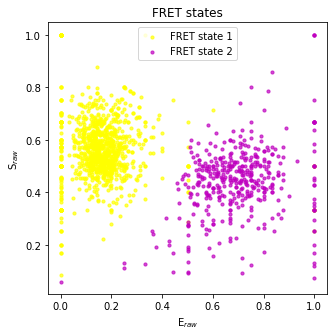

In [6]:
# make the axes
fig, ax = plt.subplots(figsize=(5,5))

# specify the states we want, now with 1 before 0
states = np.array([1, 0])
# make the state_kwargs, we'll add labels this time
state_kwargs = [{'color':'yellow', 'label':'FRET state 1'}, {'color':'m', 'label':'FRET state 2'}]

# now we plot
bhm.dwell_ES_scatter(bdata.models[2], ax=ax, states=states, state_kwargs=state_kwargs)

# add title, and legend to the plot
ax.set_title("FRET states")
ax.legend();

## State Overlays

Especially for E-S plots, burstH2MM provides a number of overlays for adding markers for where the model value of each state.

### The `scatter_ES()` function

The first, already introduced in the tutorial is the `scatter_ES()`:

> **Note**
>
> Since states often do not span the entire (0, 1) range of E and S, we manually set these in the plot bellow.
> When combined with dwell-based plots however, those plots usually automatically set the range to something reasonable.
> Therefore it is more often than not unnecessary to set the x and y axes limits.

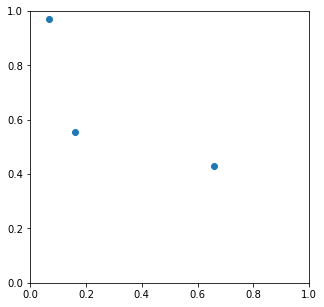

In [7]:
fig, ax = plt.subplots(figsize=(5,5))

bhm.scatter_ES(bdata.models[2], ax=ax)

ax.set_xlim([0,1])
ax.set_ylim([0,1]);

Specific states can be specified in the same way as with the other dwell-based plotting functions, through the `states` keyword argument, and `add_corrections` is also present.
Additional keyword arguments are forwarded to [ax.scatter()](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.scatter.html#matplotlib.axes.Axes.scatter)

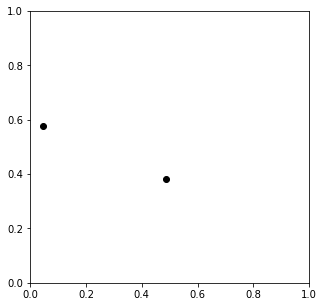

In [8]:
fig, ax = plt.subplots(figsize=(5,5))

bhm.scatter_ES(bdata.models[2], ax=ax, states=np.array([0,1]), c='k', add_corrections=True)

ax.set_xlim([0,1])
ax.set_ylim([0,1]);

### The `trans_arrow_ES()` function

Another useful function, is `trans_arrow_ES()`
This allows the incorporation of arrows indicating the transition rates directly into the plots.

We also have the standard `add_corrections` keyword argument that works the same as in all other places, whether or not to plot corrected or raw parameter values.

Under to hood, `trans_arrow_ES()` calls [ax.annotate()](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.annotate.html#matplotlib.axes.Axes.annotate), so additional keyword arguments are passed along to it, like in other `Plotting` functions.

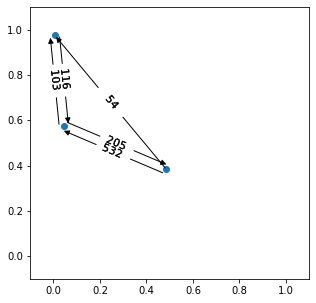

In [9]:
fig, ax = plt.subplots(figsize=(5,5))

bhm.scatter_ES(bdata.models[2], ax=ax, add_corrections=True)
bhm.trans_arrow_ES(bdata.models[2], ax=ax, add_corrections=True, fontsize=11)

ax.set_xlim([-0.1,1.1])
ax.set_ylim([-0.1,1.1]);

#### `trans_arrow_ES()` Minimum Rate Filter

If you are using the same data that this documentation was produced with, you will notice that in the above plot, one arrow seems to be missing.
Between the donor-only and high-FRET states, there is only the high-FRET to donor-only transition, but the reverse rate does not appear.
It is note because it does not exist, but rather, this rate is so slow that `trans_arrow_ES()` chooses not the plot it.

The excat threshold bellow which a transition is considered irrelevant through the `min_rate` keyword arguemnt.
The default is `min_rate=1e1`, so we know that this transition rate is slower that 10 s<sup>-1</sup>.

For the data we are using, it turns out that the transition rate is just barely under this threshold, so let's set `min_rate=1.0` so we will lower the threshold by an order of magnitude, and so see all the transition rates.

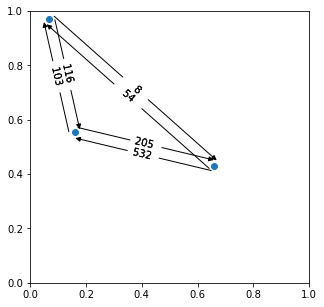

In [10]:
fig, ax = plt.subplots(figsize=(5,5))

bhm.scatter_ES(bdata.models[2], ax=ax)
bhm.trans_arrow_ES(bdata.models[2], ax=ax, min_rate=1.0)

ax.set_xlim([0,1])
ax.set_ylim([0,1]);

Of course, this default is actually rather slow, since H<sup>2</sup>MM is far more sensitive to transition rates that are on the scale of burst durations (milliseconds), let's raise the threshold so we don't see any of the transitions between the donor-only and high-FRET states:

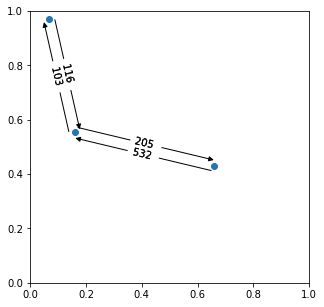

In [11]:
fig, ax = plt.subplots(figsize=(5,5))

bhm.scatter_ES(bdata.models[2], ax=ax)
bhm.trans_arrow_ES(bdata.models[2], ax=ax, min_rate=1e2)

ax.set_xlim([0,1])
ax.set_ylim([0,1]);

#### Basic `trans_arrow_ES()` customizations

Some other customizations for the display of `trans_arrow_ES()` are:
- `positions`: set where the number is displayed, either as a single number, or as an array of the same shape as the transition probability matrix
- `sep` the separation between forward and backward transition rate arrows
- `fstring` the number format for the transition rate, same as used in python f-strings
- `unit` whether to display the units of transition rate
- `rotate` whether to dispaly the transition rate rotated with the arrow, or always horizontally

So lets see some examples:

First we will set the `positions=0.4`  so instead of the numbers being placed directly in the middle, they will be a little closer to `from_state`, and we will set `fstring='1.1e` so that now units will be given in scientific notation, and we'll set `unit=True` so we can see the units:

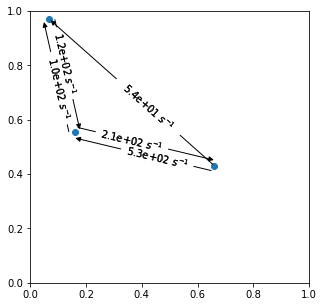

In [12]:
fig, ax = plt.subplots(figsize=(5,5))

bhm.scatter_ES(bdata.models[2], ax=ax)
bhm.trans_arrow_ES(bdata.models[2], ax=ax, positions=0.4, fstring='1.1e', unit=True)

ax.set_xlim([0,1])
ax.set_ylim([0,1]);

Now let's see the numbers horizontal and increase the separation between arrows:

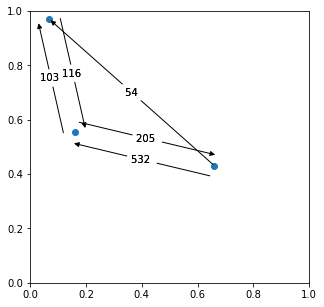

In [13]:
fig, ax = plt.subplots(figsize=(5,5))

bhm.scatter_ES(bdata.models[2], ax=ax)
bhm.trans_arrow_ES(bdata.models[2], ax=ax, sep=4e-2, rotate=False)

ax.set_xlim([0,1])
ax.set_ylim([0,1]);

Also, if you want, you can specify the `positions` as an array (organized `[from_state, to_state]`, diagonal elements ignored):

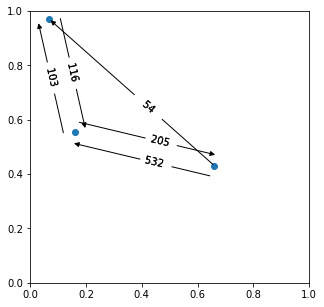

In [14]:
fig, ax = plt.subplots(figsize=(5,5))

bhm.scatter_ES(bdata.models[2], ax=ax)
pos = np.array([[0, 0.4, 0.4],[0.6, 0.0, 0.5],[0.6, 0.5, 0.0]])
bhm.trans_arrow_ES(bdata.models[2], ax=ax, sep=4e-2, positions=pos)

ax.set_xlim([0,1])
ax.set_ylim([0,1]);

#### Manually selecting states for `trans_arrow_ES()`

`trans_arrow_ES()` has `states` and `state_kwargs` keyword arguments, but they behave a little differently from those same arguments in other `Plotting` functions, becuase it is concerned with transitions, as opposed to states.

Now `states` is given as a list/tuple of 2 element arrays

> **Note**
> 
> Even if you are only plotting a single transition rate, the input to `states` must be "2-dimensional".
> Meaning that it cannot be just `[from_state, to_state]` but rather `[[from_state, to_state], ]`

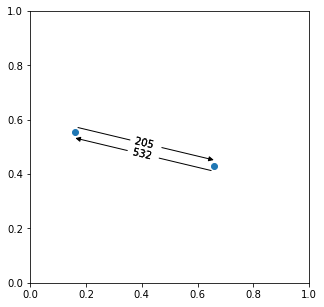

In [15]:
fig, ax = plt.subplots(figsize=(5,5))

bhm.scatter_ES(bdata.models[2], ax=ax, states=(0,1))
bhm.trans_arrow_ES(bdata.models[2], ax=ax, states=((0,1), (1,0)))

ax.set_xlim([0,1])
ax.set_ylim([0,1]);

#### Customizing the arrows

`state_kwargs` is a list of dictionaries.
The arrows in `trans_arrow_ES()`, as mentioned before are created using [ax.annotate()](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.annotate.html#matplotlib.axes.Axes.annotate) but it is a little more compliacted, as for every transition, 2 annotations are actually created.
These are the **from arrow** and **to arrow** annotations, which link the **from state** and **to state** positions to the central transition rate number.

Basically the **from arrow** starts at the rate and points to the **from state** (and by default is just a line, and thus has no arrow head).
While the **to arrow** starts at the rate and points to the **to state**.

In order to change the size, style etc. of the arrows, there are the `from_arrow`, `to_arrow` keyword arguments to set the overall arrow style, and the `from_props` and `to_props` keyword arguments set additional properties of these arguments.

> **See Also**
> 
> It is **highly** recomended to review the matplotlib documentation regarding 
> [ax.annotate()](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.annotate.html#matplotlib.axes.Axes.annotate)
> and 
> [matplotlib.patches.FancyArrowPatch](https://matplotlib.org/stable/api/_as_gen/matplotlib.patches.FancyArrowPatch.html#matplotlib.patches.FancyArrowPatch)
> as the `from_arrow`, `to_arrow`, `from_props` and `to_props` are all just repackaged into
> parts of the keyword arguments handed to these functions.
> 
> See [https://matplotlib.org/stable/tutorials/text/annotations.html](https://matplotlib.org/stable/tutorials/text/annotations.html)
> for matplotlib's tutorial regarding annotations and how to change the arrow properties
> These functions are complicated, and thus `trans_arrow_ES()` is also complicated, 
> and unfortunately the only way to really use it is through practice/experimentation and detailed reading.

Since there are two types of arrows, it is necessary to allow separate specification of certain [ax.annotate()](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.annotate.html#matplotlib.axes.Axes.annotate) keyword arguments.

Specifically, this means modifying the `arrowprops` keyword argument of [ax.annotate()](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.annotate.html#matplotlib.axes.Axes.annotate), which is itself necessarily a dictionary.
`from_arrow` and `to_arrow` arguments are packaged into the `arrowstyle` keyword argument for [matplotlib.patches.FancyArrowPatch](https://matplotlib.org/stable/api/_as_gen/matplotlib.patches.FancyArrowPatch.html#matplotlib.patches.FancyArrowPatch), which is handed there via the `arrowprops` keyword argument of [ax.annotate()](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.annotate.html#matplotlib.axes.Axes.annotate), by _updating_ the default dictionary with the user provided arguments, so defaults are not lost.

`from_props` and `to_props` are packaged into the `arrowprops` keyword argument, and thus serve as other keyword arguments to [matplotlib.patches.FancyArrowPatch](https://matplotlib.org/stable/api/_as_gen/matplotlib.patches.FancyArrowPatch.html#matplotlib.patches.FancyArrowPatch), again, by _updating_ the default dictionaries so defaults are not lost.

Finally, there is the `arrowprops` keyword argument, which is basically a way of passing the same argument to both `from_props` and `to_props`, and again it works by _updating_ the dictionaries.

So let's see examples of how these work:

The thickness and color of the arrows can be set in the `arrowprops` via the key `linewidth`:

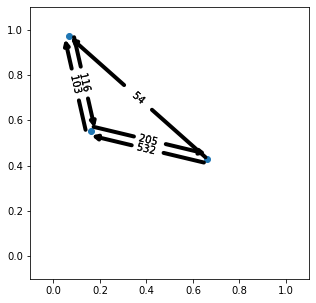

In [16]:
fig, ax = plt.subplots(figsize=(5,5))

bhm.scatter_ES(bdata.models[2], ax=ax)
bhm.trans_arrow_ES(bdata.models[2], ax=ax, arrowprops=dict(linewidth=4.0))

ax.set_xlim([-0.1,1.1])
ax.set_ylim([-0.1,1.1]);

We can give individual colors or different linewidths to the **from arrow** and **to arrow** with the `from_arrow` and `to_arrow` keyword arguments:

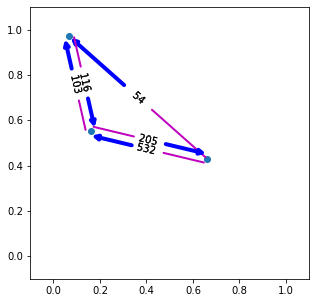

In [17]:
fig, ax = plt.subplots(figsize=(5,5))

bhm.scatter_ES(bdata.models[2], ax=ax)
bhm.trans_arrow_ES(bdata.models[2], ax=ax, from_props=dict(linewidth=2.0, color='m'),
                   to_props=dict(linewidth=4.0, color='b'))

ax.set_xlim([-0.1,1.1])
ax.set_ylim([-0.1,1.1]);

As you will note near the top of the matplotlib documentation pages, passing some strings to `from_arrow` and `to_arrow` can make the arrows take on different shapes at their ends:

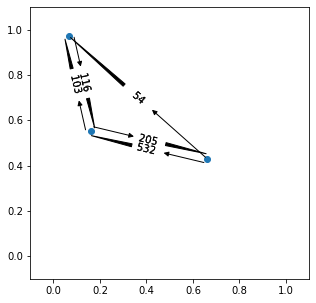

In [18]:
fig, ax = plt.subplots(figsize=(5,5))

bhm.scatter_ES(bdata.models[2], ax=ax)
bhm.trans_arrow_ES(bdata.models[2], ax=ax, to_arrow='wedge', from_arrow='<|-')

ax.set_xlim([-0.1,1.1])
ax.set_ylim([-0.1,1.1]);

### `axline_E()` and `axline_S()`

For times when you want to plot histograms, there also are a set of functions that plot bars for states.
We have `axline_E()`, and `axline_S()`, which have the same fundamental function signature.

The `add_corrections`, `states` and `state_kwargs` keyword arguments all work the same as in `scatter_ES()`.
So `add_corrections` sets whether or not to plot the corrected values, as opposed to the raw values. 
`states` is an array of the states that are to be plotted, and `state_kwargs` is a list or tuple of dictionaries that are the keyword arguments for either [ax.axvline()](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.axvline.html#matplotlib.axes.Axes.axvline) or [ax.axhline()](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.axhline.html#matplotlib.axes.Axes.axhline).

There is a keyword argument `horizontal` that sets whether to plot horizontal bars (`horizontal=True`) or the default of vertical bars (`horizontal=False`).

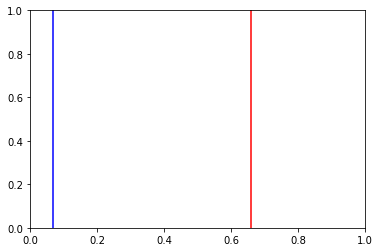

In [19]:
fig, ax = plt.subplots()

bhm.axline_E(bdata.models[2], states=np.array([0,2]), state_kwargs=({'c':'r'}, {'c':'b'}))

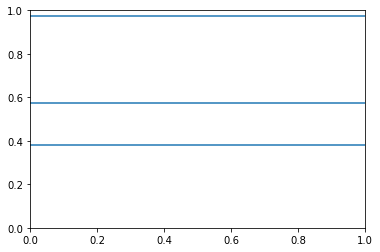

In [20]:
fig, ax = plt.subplots()

bhm.axline_S(bdata.models[2], add_corrections=True, horizontal=True)

## Selecting photon streams

But what about the `H2MM_result.dwell_nano_mean` parameter? 
It has not only information per state, but also information per stream. 
Some other dwell parameters are similar. 
To select and/or specify a stream, we have the streams keyword argument, and the `stream_kwargs` keyword argument to customize those plotting for those functions as well. 
For this we will use the `dwell_tau_hist()` function.

> **Warning**
>
> Remember to set the `irf_thresh` (see the [divisor approach](#divisorapproach) section of the tutorial for more explanation.
> This should be done once, before a paremeter based on nanotimes is accessed

In [21]:
bdata.irf_thresh = np.array([2355, 2305, 220])

Now we can see the default appearance of `dwell_tau_hist()`:

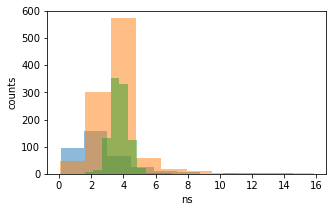

In [22]:
fig, ax = plt.subplots(figsize=(5, 3))
bhm.dwell_tau_hist(bdata.models[2], ax=ax);

By default, `dwell_tau_hist()` only shows the mean nanotimes for the D<sub>ex</sub>D<sub>em</sub> photon stream. 
But what if we wanted to look at a different stream? 
To do this we use the `streams` keyword argument. 
It functions like the `states` keyword argument before (introduced in [Displaying subsets of states](#statedisp)).

So, let’s look at the D<sub>ex</sub>D<sub>em</sub> and D<sub>ex</sub>A<sub>em</sub> streams:

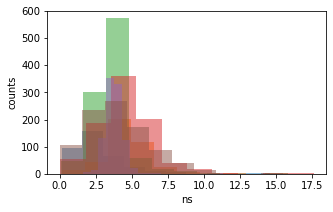

In [23]:
fig, ax = plt.subplots(figsize=(5, 3))
streams = [frb.Ph_sel(Dex="Dem"), frb.Ph_sel(Dex="Aem")]
bhm.dwell_tau_hist(bdata.models[2], ax=ax, streams=streams);

Or just the D<sub>ex</sub>A<sub>em</sub> stream:

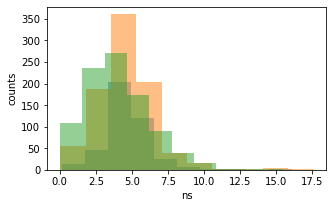

In [24]:
fig, ax = plt.subplots(figsize=(5, 3))
streams = [frb.Ph_sel(Dex="Aem")]
bhm.dwell_tau_hist(bdata.models[2], ax=ax, streams=streams);

### Customizing plotting of photon streams

For plots where there are specific selections per stream in addition to per state, the `stream_kwargs` keyword argument exists. 
It functions much like the `state_kwargs` argument, matching the order of streams and needing to be the same length.

Also, `state_kwargs` and `stream_kwargs` merge dictionaries, so you can specify both, and not have a problem.

So let’s see an example:

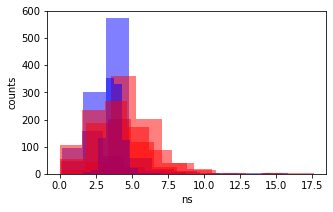

In [25]:
fig, ax = plt.subplots(figsize=(5, 3))
streams = [frb.Ph_sel(Dex="Dem"), frb.Ph_sel(Dex="Aem")]
stream_kw = [{'color':'b'}, {'color':'r'}]
bhm.dwell_tau_hist(bdata.models[2], ax=ax, streams=streams, stream_kwargs=stream_kw);

But now, the problem is we have no idea which state goes with what, so let’s use the `states` keyword argument to specify only the 0th state:

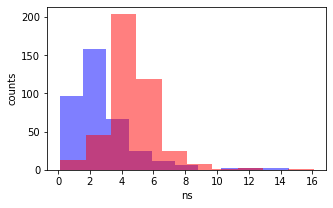

In [26]:
fig, ax = plt.subplots(figsize=(5, 3))
streams = [frb.Ph_sel(Dex="Dem"), frb.Ph_sel(Dex="Aem")]
stream_kw = [{'color':'b'}, {'color':'r'}]
state = np.array([0])
bhm.dwell_tau_hist(bdata.models[2], ax=ax, streams=streams, stream_kwargs=stream_kw, states=state);

Finally, `stream_kwargs` and `state_kwargs` work together: the two dictionaries for a particular stream and state combination are merged:

> **Note**
> 
> In the dictionary merging process, if the same key is present in both dictionaries, then the value in `stream_kwargs` will be used, and the values in `state_kwargs` over-written.

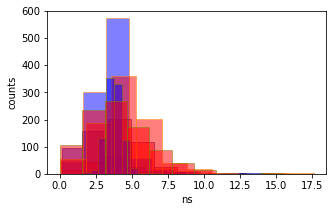

In [27]:
fig, ax = plt.subplots(figsize=(5, 3))
streams = [frb.Ph_sel(Dex="Dem"), frb.Ph_sel(Dex="Aem")]
stream_kw = [{'color':'b'}, {'color':'r'}]
state_kw = [{'edgecolor':'darkblue'}, {'edgecolor':'darkorange'}, {'edgecolor':'olive'}]
bhm.dwell_tau_hist(bdata.models[2], ax=ax, streams=streams, stream_kwargs=stream_kw, state_kwargs=state_kw);

### Control of Plotting State and Stream in Unified Argument Array

Now, sometimes you need even more control, because the two keyword argument arrays clash. For this there is the kwarg_arr keyword argument. In kwarg_arr, you provide an array of dictionaries that will be the keyword arguments for [ax.scatter()](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.scatter.html#matplotlib.axes.Axes.scatter) , the outer dimension indicates which state, and the inner dimension indicates which the stream.

> **Note**
> 
> `kwarg_arr` is meant to take the place of the combination of `state_kwargs` and `stream_kwargs`. 
> As such, `kwarg_arr` and `state_kwargs` cannot be specified at the same time. If `stream_kwargs` is specified at the same time as `kwarg_arr`, then burstH2MM will make a check. 
> If `kwarg_arr` is formatted like `state_kwargs`, then it will be treated like `state_kwargs`. 
> On the other hand, if it is formatted as demonstrated below, `stream_kwargs` will be ignored, and a warning will be presented.

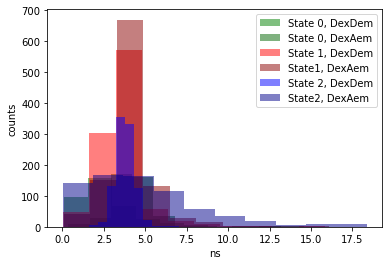

In [28]:
fig, ax = plt.subplots(figsize=(6, 4))
kwarr = [[{'color':'g', 'label':'State 0, DexDem'},
          {'color':'darkgreen', 'label':'State 0, DexAem'}],
         [{'color':'r', 'label':'State 1, DexDem'},
          {'color':'darkred', 'label':'State1, DexAem'}],
         [{'color':'b', 'label':'State 2, DexDem'},
          {'color':'darkblue', 'label':'State2, DexAem'}]]
bhm.dwell_tau_hist(bdata.models[2], ax=ax, kwarg_arr=kwarr, streams=[frb.Ph_sel(Dex="Dem"), frb.Ph_sel(Aex="Aem")])
ax.legend();

So `kwarg_arr` allows the most customization, but is also the longest to define.

## Plotting by dwell position and masking

Dwell based plotting functions also include the `dwell_pos` keyword arguments. 
This arguments allows the user to filter which dwells are plotted, not by state, but by the position (middle of the burst, start, stop or whole), and in its most advanced usage, by any user defined criterion. 
There are several possible types of inputs to `dwell_pos`, but the most easily understood is by using one of the functions in the `Masking` module (see [Using masking functions to make masks](#usemaskfunc)).

So let’s see `dwell_pos` in action:

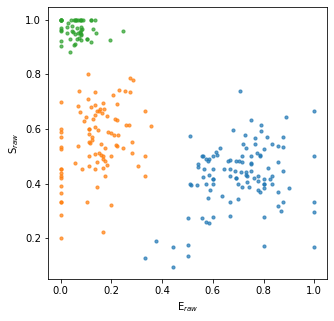

In [29]:
fig, ax = plt.subplots(figsize=(5,5))
# plot only dwells in the middle of a burst
bhm.dwell_ES_scatter(bdata.models[2], dwell_pos=bhm.mid_dwell, ax=ax);

> **Note**
> 
> Functions handed to the `dwell_pos` keyword argument must accept a `H2MM_result` objects as input, and return a mask of dwells

You will note many fewer points, as there are many beginning, ending and whole burst dwells removed.

It is also possible to specify dwells by specifying `dwell_pos` as an integer corresponding to the dwell position code used in the similarly named `H2MM_result.dwell_pos` parameter.

So to select the mid dwells, we give it 0:

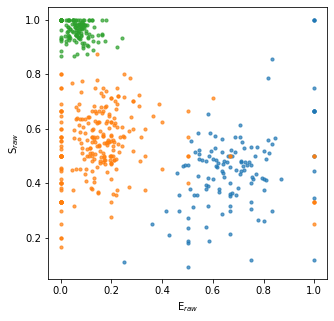

In [30]:
fig, ax = plt.subplots(figsize=(5,5))
# plot only dwells in the middle of a burst
bhm.dwell_ES_scatter(bdata.models[2], dwell_pos=1, ax=ax);

And to select the beginning of bursts:

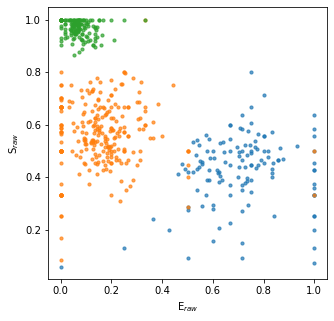

In [31]:
fig, ax = plt.subplots(figsize=(5,5))
# plot only dwells in the middle of a burst
bhm.dwell_ES_scatter(bdata.models[2], dwell_pos=2, ax=ax);

It is also possible to select multiple types of dwells by using an array of all interested codes:

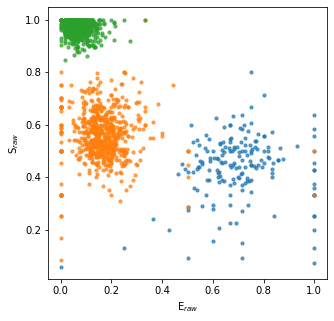

In [32]:
fig, ax = plt.subplots(figsize=(5,5))
# make array of code selections (beginning and whole burst dwells)
pos_sel = np.array([2,3])
# plot the selection
bhm.dwell_ES_scatter(bdata.models[2], dwell_pos=pos_sel, ax=ax);

Another method is to provide a mask of all the dwells, for example, all dwells with a stoichiometry greater than some threshold:

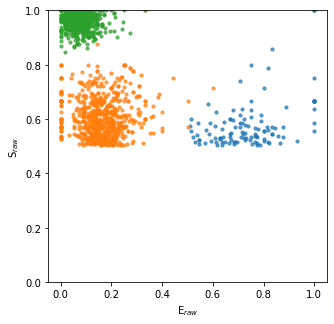

In [33]:
fig, ax = plt.subplots(figsize=(5,5))
# make mask of dwells with stoichiometry greater than 0.5
dwell_mask = bdata.models[2].dwell_S > 0.5
# plot with a mask
bhm.dwell_ES_scatter(bdata.models[2], dwell_pos=dwell_mask, ax=ax)
# ensure full S range is plotted
ax.set_ylim([0,1]);

Now the previous example plots a selection that is not very useful, however, what if we want to exclude dwells with fewer than a certain number of photons? 
Well, you could use `H2MM_result.dwell_ph_counts` to make a mask, but there is one `Masking` function that is different from the others, and will not work directly as an input to `dwell_pos`: this is `dwell_size()` which needs at least a minimum number of photons as input. 
So here, we will employ a Python `lambda` function:

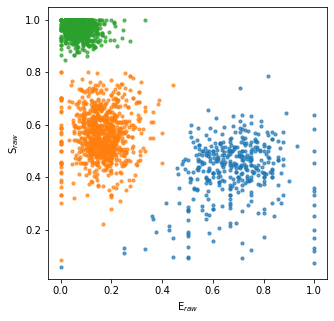

In [34]:
fig, ax = plt.subplots(figsize=(5,5))
# plot with lambda function, sets ph_min at 10
bhm.dwell_ES_scatter(bdata.models[2], dwell_pos= lambda m: bhm.dwell_size(m, 10), ax=ax);

Thus you can hand functions that take `H2MM_result` object as input, and returns a mask as output to select dwells based on whatever parameters you want.

<a id='burstbasedplot'></a>
## Burst Based Plotting

What if you want to look not at individual dwells, but at how bursts differ based on the bursts within them? 
For that there are the burst-based plots. 
There is currently 1 burst-based plotting function, but more are likely to come in future versions. 
This is `burst_ES_scatter()`

Now, instead of segmenting the data into dwells, we consider entire bursts, based on what states are present within them. 
Under the hood, this is achieved using the `H2MM_result.burst_type` attribute. 
This means the plots will now have points at the same positions as FRETBursts plotting functions, but will gain additional formatting depending on what states are present within them.

> **See also**
> 
> [Burst Based Arrays](#burstbasedarrays) to understand how to directly access the numbers being plotted in the followig section.

So let’s look at the basic plot produced from `burst_ES_scatter()`

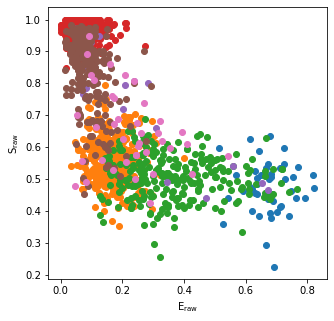

In [35]:
fig, ax = plt.subplots(figsize=(5,5))
bhm.burst_ES_scatter(bdata.models[2], ax=ax);

Now this plot has a lot of colors in it, and they aren’t labeled. 
The number of colors scales with the square of the number of states, so you can imagine these plots get busy quickly. 
So there is a keyword argument: `flatten_dynamics`. 
If `flatten_dynamics=True` and then bursts will only be distinguished by whether any sort of transition occurs or if they only contain a single dwell/state:

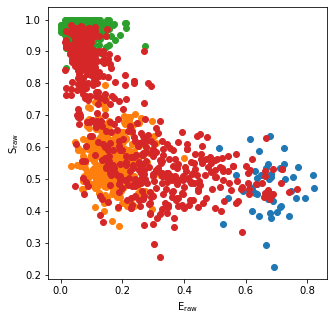

In [36]:
fig, ax = plt.subplots(figsize=(5,5))
bhm.burst_ES_scatter(bdata.models[2], flatten_dynamics=True,  ax=ax);

Finally, if you want to control the plotting by burst type, much like the state_kwargs keyword argument, there is the `type_kwargs` keyword argument. 
So, what is the order that the list needs to be given? 
Well that depends on if flatten_dynamics is `True` or `False`.

If it is `False`, then the order is based on the binary order, so it will go State0 only, then **State1** only, then **State1** and **State0**, then **State2** etc:

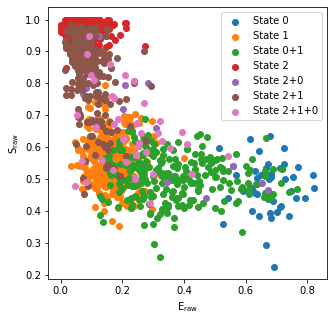

In [37]:
fig, ax = plt.subplots(figsize=(5,5))
type_kwargs = [
    {'label':'State 0'}, {'label':'State 1'},
    {'label':'State 0+1'}, {'label':'State 2'},
    {'label':'State 2+0'}, {'label':'State 2+1'},
    {'label':'State 2+1+0'}
]
bhm.burst_ES_scatter(bdata.models[2],type_kwargs=type_kwargs, ax=ax)
ax.legend();

If `True` then the order is simply **State0**, **State1** … then finally, the last element will be “dynamic” bursts, i.e. a burst with any sort of dynamics:

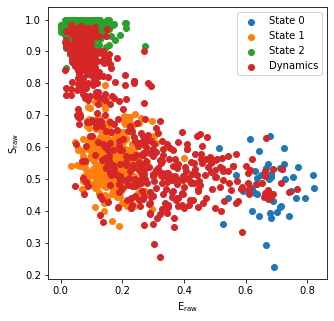

In [38]:
fig, ax = plt.subplots(figsize=(5,5))
type_kwargs = [
    {'label':'State 0'}, {'label':'State 1'},
    {'label':'State 2'}, {'label':'Dynamics'}
]
bhm.burst_ES_scatter(bdata.models[2],flatten_dynamics=True, type_kwargs=type_kwargs, ax=ax)
ax.legend();

That's the end of this How-To, thank you for using burstH2MM.